# Dynamical decoupling of a non-Markovian environment


### Introduction

In [1]:
%pylab inline
from qutip import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [27]:
from heom_fmotd import BosonicHEOMSolver as BosonicHEOMSolverOld
from qobj_heom_fmotd import BosonicHEOMSolver as QobjEvoSolve
from qobj_heom_fmotd import BosonicHEOMSolver 

In [25]:


from qobj_heom_fmotd_py import BosonicHEOMSolver as QobjEvoSolve

from qobj_heom_fmotd_py import BosonicHEOMSolver as BosonicHEOMSolver


In [5]:
#non-secular master equation 

import time
import warnings
import numpy as np
import scipy.sparse as sp
from numpy import matrix
from numpy import linalg
from qutip import spre, spost, sprepost, thermal_dm, mesolve, Odeoptions
from qutip import tensor, identity, destroy, sigmax, sigmaz, basis, qeye, dims
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar
def Lnonsec(Hsys, Qlist, tlist, initial_state, Temperature,
            return_vals, eigen_sparse=False, options=None,progress_bar=None):
    

    if progress_bar is None:
        progress_bar = BaseProgressBar()
    elif progress_bar is True:
        progress_bar = TextProgressBar()
        
    if options is None:
        options = Options()
    output = None
    
    dot_energy, dot_state = Hsys.eigenstates(sparse=eigen_sparse)
    deltaE = dot_energy[1] - dot_energy[0]
    
    
    
    
    dimensions = dims(Qlist[0])
    Nmax = dimensions[1][0]        #hilbert space
    print(Nmax)
    #Nmax = 2       #hilbert space 
    
    H = Hsys
    L=0.*spre(Qlist[0])
    PsipreEta=0
    PsipreX=0

    all_energy, all_state = H.eigenstates(sparse=eigen_sparse)
    
    for Q in Qlist:
        Apre = spre(Q)
        Apost = spost(Q)
        for j in range(Nmax):
            for k in range(Nmax):
                A = Q.matrix_element(all_state[j].dag(), all_state[k])
                #A = sh.matrix_element(all_state[j].dag(), all_state[k])
                delE = (all_energy[j] - all_energy[k])
                if np.absolute(A) > 0.0:
                    if abs(delE) > 0.0:
                        #X = (0.5 * np.pi * gamma*(all_energy[j] - all_energy[k])
                        X = (0.5  * J0(all_energy[j] - all_energy[k])
                             * (np.cosh((all_energy[j] - all_energy[k]) /
                                (2 * Temperature))
                             / (np.sinh((all_energy[j] - all_energy[k]) /
                                (2 * Temperature)))) * A)
                        #eta = (0.5 * np.pi * gamma *
                        eta = (0.5 *  
                               J0(all_energy[j] - all_energy[k]) * A)
                        PsipreX = PsipreX + X * all_state[j]*all_state[k].dag()
                        PsipreEta = PsipreEta + (eta * all_state[j]
                                                 * all_state[k].dag())
                    else:
                        #X =0.5  * np.pi* J0(0.) * A * 2 * Temperature
                        X =0.5  *  J02(0.)* A  * 2 * Temperature
                        #X =0.5 * np.pi * gamma * A * 2 * Temperature
                        PsipreX=PsipreX+X*all_state[j]*all_state[k].dag()

        A = Q
        L += ((-spre(A * PsipreX)) + (sprepost(A, PsipreX))
             +(sprepost(PsipreX, A)) + (-spost(PsipreX * A))
             +(spre(A * PsipreEta)) + (sprepost(A, PsipreEta))
             +(-sprepost(PsipreEta, A)) + (-spost(PsipreEta * A)))           

    #Setup the operators and the Hamiltonian and the master equation 
    #and solve for time steps in tlist
    psi0 = ( initial_state)
    output = mesolve(H, psi0, tlist, [L], return_vals, options=options,progress_bar=progress_bar)
    
    return output
              

In [6]:

def coth(x):
    """
    coth function
    """
    return 1./np.tanh(x)

def cot(x):
    return 1./np.tan(x)


def J0(energy):
    #underdamped brownian oscillator
    return 2 * lam * gamma * (energy)/(((energy**2) + (gamma**2)))
def nbs(energy,Temperature):
    beta=1./Temperature
    
    return 1./(np.exp(energy*beta) - 1.)

#spectral density/w at w=0
def J02(energy):
    #underdamped brownian oscillator
    return 2 * lam * gamma /( ((gamma**2)))

Followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733 we consider an example of dynamical decoupling
we choose a drive which performs pi/2 rotations, interspersed with short periods where the bath causes dephasing
 
The first example is the full evolution with the natural precession, almost no nosie, and a time-dependant resonant drive performing pi/2 pulses.   

Text(0, 0.5, 'J')

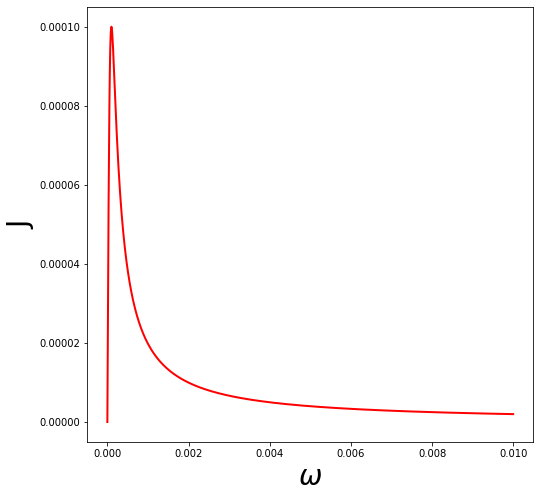

In [16]:
#dynamical decoupling test
wq = 20.0
Hsys = wq * 0.5 * sigmaz()


pref = 1.
#K is the matsubara terms; if temperature < system energy,  N>1
Nk=1

Q=sigmaz()
T= 1.
beta=1./T
#beta = 1/10.

lam = 0.0001
gamma = 0.0001


wlist = np.linspace(0, 0.01, 1000)
pref = 1.

J = [w * 2 * lam * gamma / ((gamma**2 + w**2)) for w in wlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [28]:

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]


NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)


ttotal=50.
tlist2 = np.linspace(0, ttotal, 50000)


#Pure dephasing example: start with a superposition so there is something to dephase!
sup = (basis(2,1)+basis(2,0))/sqrt(2.)
initial_state2= sup * sup.dag()

optionsODE = Options(nsteps=1500, store_states=True,rtol=1e-12,atol=1e-12)


NC = 60

HEOM = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=optionsODE)

outputold =  HEOM.run(initial_state2, tlist2)



#followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733
#I added the t_p dependence to the pulse design in equation 19/20
#I omitted sigma_y (why is it there? do we need it?)
#I think i need it....  will have to edit the code again. cry
def drive(t):
    V = .5
#    tp = pi/(2.*V)
#I think there is a typo/error in seth lloyd, they dont take into account
#the 1/2 from the cosine.  its a minor thing
    tp = pi/(V)
    delt = 20
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                RF += V*cos(wq*(t-n*delt-(n-1)*tp))
    return RF

V = .5
tp = pi/(V)
#    tp = pi/(V)
delt = 20
N = int(ttotal/(tp + delt))
print(N)
H_d = [sigmax(), drive]

Ncc = 60


H_d = [Hsys,[sigmax(), drive]]



Q2 = [Q for kk in range(NR+NI)]



print("old c code")
start = time.time()
optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-17,atol=1e-17)
resultHEOMOld = BosonicHEOMSolverOld(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDDL  = resultHEOMOld.run(initial_state2,tlist2)
end = time.time()
print(end-start)


#Q = [sigmax(),sigmax(),sigmax(),sigmax()]
Q2 = [Q for kk in range(NR+NI)]



print("c code lists")
start = time.time()
optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-17,atol=1e-17)
resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDDL  = resultHEOM.run(initial_state2,tlist2)
end = time.time()
print(end-start)


Q2 = [Q for kk in range(NR+NI)]
print("c code qobjevo")
start = time.time()
Hevo = QobjEvo([Hsys, [sigmax(), drive]])
resultHEOMEvo = QobjEvoSolve(Hevo, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputDD  = resultHEOMEvo.run(initial_state2,tlist2)
end = time.time()
print(end-start)


H_d = [Hsys,[0.*sigmax(), drive]]


#Q = [sigmax(),sigmax(),sigmax(),sigmax()]
Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, NC, options=optionsODE)
outputnoDD  = resultHEOM.run(initial_state2,tlist2)


#resultHEOM=heom_fmo.HSolverDLMultiBathsWithRes(id4state, Q,  lam0,Temperature, Ncc+1, Kk, gamma,res_list,renorm=True,options=optionsODE,bnd_cut_approx=True)
#outputQ2=resultHEOM.run(initial_state,tlist)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]
1
old c code
45.831493854522705
c code lists
46.51551294326782
c code qobjevo
45.403581857681274


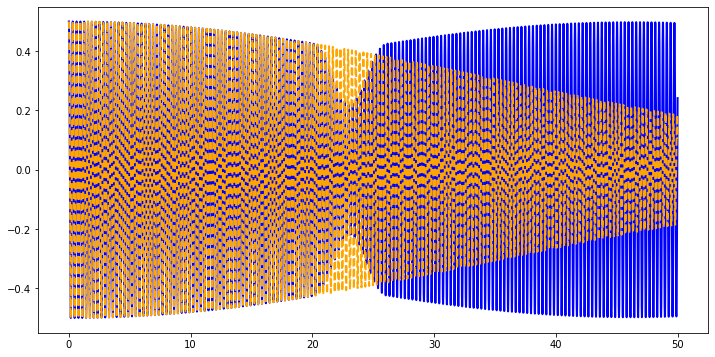

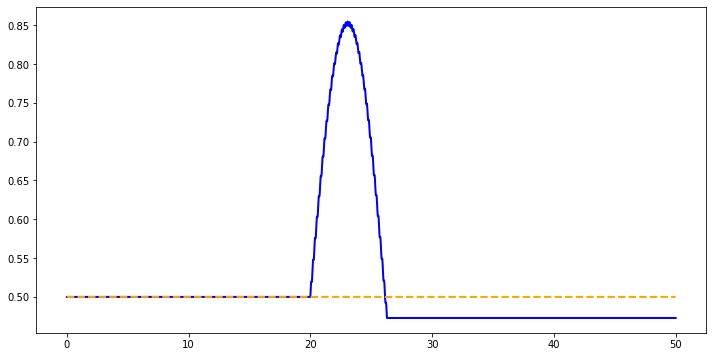

In [18]:
#P2HEOM=expect(output.states,P2)



P12DD=expect(outputDD.states,basis(2,1)*basis(2,0).dag())
P12DDL=expect(outputDDL.states,basis(2,1)*basis(2,0).dag())
P12noDD=expect(outputnoDD.states,basis(2,1)*basis(2,0).dag())

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, real(P12DDL), 'blue', linestyle='-', linewidth=2, label="P12 dd")
#axes2.plot(tlist2, real(P12DD), 'blue', linestyle='-', linewidth=2, label="P12 dd")
axes2.plot(tlist2, real(P12noDD), 'orange', linestyle='--', linewidth=2, label="P12 no dd")

#P2HEOM=expect(output.states,P2)


P1DD=expect(outputDDL.states,basis(2,1)*basis(2,1).dag())
P1noDD=expect(outputnoDD.states,basis(2,1)*basis(2,1).dag())

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, real(P1DD), 'blue', linestyle='-', linewidth=2, label="P12 dd")
axes2.plot(tlist2, real(P1noDD), 'orange', linestyle='--', linewidth=2, label="P12 no dd")

In [ ]:

# Lets look at the drive itself:

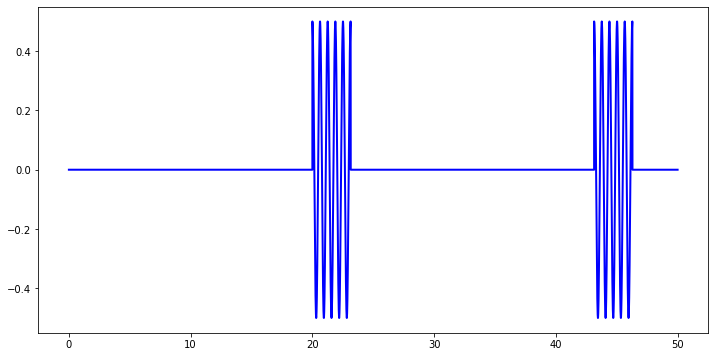

In [32]:

ttotal=50.
tlist2 = np.linspace(0, ttotal, 50000)

def drive(t):
    V = .5
    tp = pi/(2.*V)
#    tp = pi/(V)
    delt = 20
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                RF += V*cos(wq*(t-n*delt-(n-1)*tp))
    return RF

pulse = [drive(t) for t in tlist2]

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, pulse, 'blue', linestyle='-', linewidth=2, label="P12 dd")


#P2HEOM=expect(output.states,P2)



# Here we remove the natural precession, and make a RWA on the drive (i.e. this is equivalent to being in an interaction picture, and making an RWA) 
# This is slightly more convenient to play with than the above example

In [12]:
#dynamical decoupling test
wq = 10.0
Hsys = wq * 0.0 * sigmaz()


#
#K is the matsubara terms; if temperature < system energy,  N>1
Kk=1

Q=sigmaz()

beta=1./1.
#beta = 1/10.
T=1.



lam = 0.01


gamma = 0.1


ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]



ttotal=20.
tlist2 = np.linspace(0, ttotal, 20000)
#Pure dephasing example: start with a superposition so there is something to dephase!
sup = (basis(2,1)+basis(2,0))/sqrt(2.)
initial_state2= sup * sup.dag()

optionsODE = Options(nsteps=1500, store_states=True,rtol=1e-12,atol=1e-12)

NC = 60
Q2 = [Q for kk in range(NR+NI)]

HEOM = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=optionsODE)

outputold =  HEOM.run(initial_state2, tlist2)


#followings https://journals.aps.org/pra/pdf/10.1103/PhysRevA.58.2733
#in this version i replace the drive with 
#pi/2 pulse stuff, assuming interaction picture
#so h_sys = 0
#H_drive = V\sigma_x when t in {tp} period
#this lets me set V arbitrarily large without worrying about RWA violation

def drive(t):
    V = 10.
    tp = pi/(2.*V)
#    tp = pi/(V)
    delt = 1.
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                #RF += V*cos(wq*(t-n*delt-(n-1)*tp))
                RF += V
    return RF




Ncc = 60


H_d = [Hsys,[sigmax(), drive]]


#Q = [sigmax(),sigmax(),sigmax(),sigmax()]
Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, Ncc, options=optionsODE)
outputDD  = resultHEOM.run(initial_state2,tlist2)



Ncc = 60


H_d = [Hsys,[0.*sigmax(), drive]]


#Q = [sigmax(),sigmax(),sigmax(),sigmax()]
Q2 = [Q for kk in range(NR+NI)]

resultHEOM = BosonicHEOMSolver(H_d, Q2,ckAR,ckAI,vkAR,vkAI, Ncc, options=optionsODE)
outputnoDD  = resultHEOM.run(initial_state2,tlist2)


#resultHEOM=heom_fmo.HSolverDLMultiBathsWithRes(id4state, Q,  lam0,Temperature, Ncc+1, Kk, gamma,res_list,renorm=True,options=optionsODE,bnd_cut_approx=True)
#outputQ2=resultHEOM.run(initial_state,tlist)

In [13]:
def drive(t,args):
    V = 10.
    tp = pi/(2.*V)
#    tp = pi/(V)
    delt = 1.
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                #RF += V*cos(wq*(t-n*delt-(n-1)*tp))
                RF += V
    return RF

#lam=lam2
#gamma = gamres
T= 1.
beta = 1./T
#this is a really bad approximation for small gamma.  gives a huge dephasing rate
approx_factr = ((2.*lam / (beta*gamma)) - 1.0j*lam)

#lets reduce it
approx_factr = ((2.*lam / (beta)))



resultMEDD= mesolve([Hsys,[sigmax(), drive]], initial_state2, tlist2, [np.sqrt(2.*approx_factr)*sigmaz()], [])
resultMEnoDD= mesolve(Hsys, initial_state2, tlist2, [np.sqrt(2.*approx_factr)*sigmaz()], [])




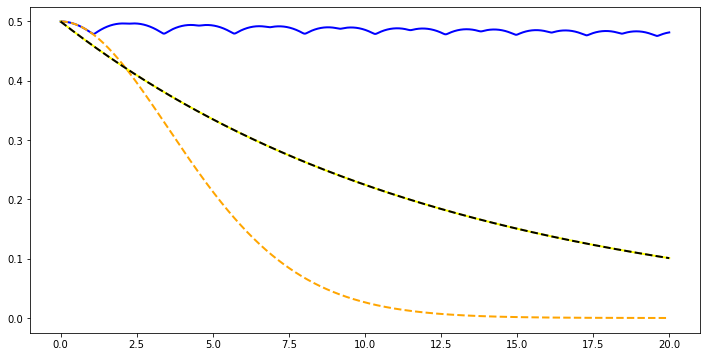

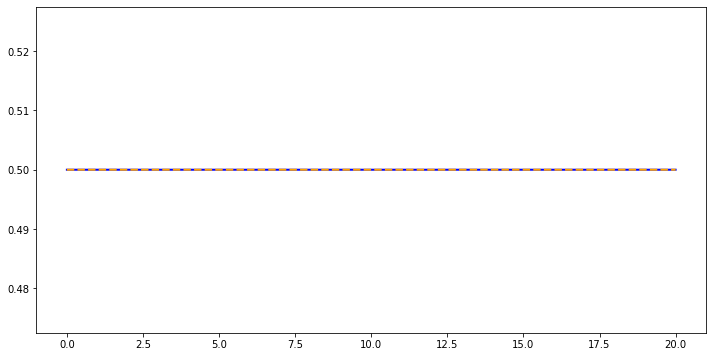

In [14]:
#P2HEOM=expect(output.states,P2)


P12DD=expect(outputDD.states,basis(2,1)*basis(2,0).dag())
P12noDD=expect(outputnoDD.states,basis(2,1)*basis(2,0).dag())

P12MEDD=expect(resultMEDD.states,basis(2,1)*basis(2,0).dag())
P12MEnoDD=expect(resultMEnoDD.states,basis(2,1)*basis(2,0).dag())

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, real(P12DD), 'blue', linestyle='-', linewidth=2, label="P12 dd")
axes2.plot(tlist2, real(P12noDD), 'orange', linestyle='--', linewidth=2, label="P12 no dd")

axes2.plot(tlist2, real(P12MEDD), 'yellow', linestyle='-', linewidth=2, label="P12 no dd")
axes2.plot(tlist2, real(P12MEnoDD), 'black', linestyle='--', linewidth=2, label="P12 no dd")

#P2HEOM=expect(output.states,P2)


P1DD=expect(outputDD.states,basis(2,1)*basis(2,1).dag())
P1noDD=expect(outputnoDD.states,basis(2,1)*basis(2,1).dag())

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, real(P1DD), 'blue', linestyle='-', linewidth=2, label="P12 dd")
axes2.plot(tlist2, real(P1noDD), 'orange', linestyle='--', linewidth=2, label="P12 no dd")

In [131]:
sx = sigmax()
sz = sigmaz()

In [130]:
basis(2,0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 1.]
 [ 0.]]

In [136]:
(1.0j*(pi)*sx).expm()*basis(2,0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]]

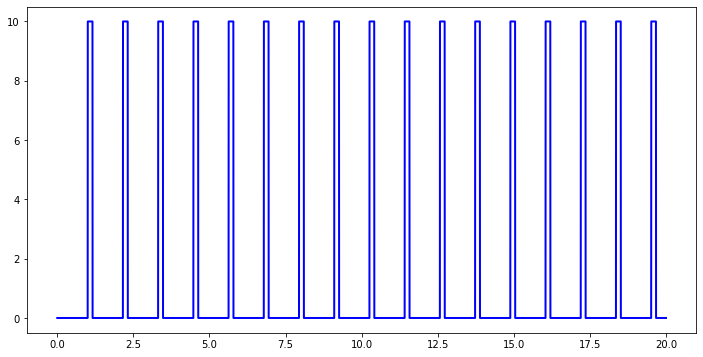

In [47]:

def drive(t):
    V = 10.
    tp = pi/(2.*V)
#    tp = pi/(V)
    delt = 1.
    N = int(ttotal/(tp + delt))
    RF = 0.
    for n in arange(1,N+1):
        if t >= n*delt+(n-1)*tp:
            if t<=n*delt + n*tp:
                
                #RF += V*cos(wq*(t-n*delt-(n-1)*tp))
                RF += V
    return RF


pulse = [drive(t) for t in tlist2]

fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))



axes2.plot(tlist2, pulse, 'blue', linestyle='-', linewidth=2, label="P12 dd")


#P2HEOM=expect(output.states,P2)

